# Lab 4: Basic Text Sequence Analysis with Recurrent Nets


This lab will largely mimic our work in recent lectures.

Our goals are to:

1. Create a vocabulary and train an embedding matrix using the **continuous bag of words model**.
2. **Text Classification:** Load the works of Shakespeare as well as War and Peace by Leo Tolstoy, create a joint vocabulary, and then classify sentences as either Shakespeare or Tolstoy. We will use the embedding matrix trained in the first step.
3. Make a **character generation model** using the works of Shakespeare (so extremely similar to our War and Peace text generator).

We will use long short term memory (LSTM) cells for all our recurrent layers (we generally used GRU cells for the in-class examples)

You should be able to mostly follow the work presented in the recent notebooks to complete this lab.

In [81]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#PyTorch Libraries
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

#You will also likely need:
import re
from collections import Counter

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Part 1: Word Embeddings with Word2Vec CBOW

## Load our texts

Load the Complete Works of Shakespeare and War and Peace by Leo Tolstoy texts by running the following cell:

In [82]:
with open('war_and_peace.txt', 'r', encoding="utf8") as file:
    war_txt = file.read()

with open('shakespeare.txt', 'r', encoding="utf8") as file:
    shakespeare_txt = file.read()

## Build Tokenizer

- Write a function named `tokenizer()` that takes a text as its input, and:
    1. Removes any non-alphanumeric characters *except for periods*
    2. Pads any periods with spaces so that they treated as separate tokens
    3. Lowers the text
    4. Returns the text split into tokens
    

Confirm that it seems to tokenize our texts properly by giving the output on at least one of the texts.

In [83]:
def tokenizer(text):
    text = re.sub(r'[^a-zA-Z0-9\s.]', '', text)
    text = re.sub(r'\.', ' . ', text)
    text = text.lower()
    return text.split()
war_tokens = tokenizer(war_txt)
shakespeare_tokens = tokenizer(shakespeare_txt)
shakespeare_tokens[:20]

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'complete',
 'works',
 'of',
 'william',
 'shakespeare',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere']

## Build the Vocabulary

Now, build a master vocabulary that includes all words from both of our texts:

- This vocabulary should be a dictionary with the word the key and an (arbitrary) scalar the value.
- Keep only words that appear at least 10 times
- Include two special tokens for padding and unknown words
- Also create a reverse vocabulary that maps from a scalar to the associated word
- Save the vocabulary length as a variable
- Write a helper function that yields an appropriate list of scalars given an input text

Then:

1. Display the first few entries of both your vocabulary and reverse vocabulary to confirm construction.
2. Give the output of your helper function for the test sentence `"To be or not to asdf"`

In [84]:
token_counts = Counter()
text_new = war_tokens+shakespeare_tokens

for text in text_new:
    
    tokenized = tokenizer(text)
    
    token_counts.update(tokenized)

In [85]:
min_appearances = 10

word_list = []

for word, count in token_counts.most_common():
    if (count >= min_appearances):
        word_list.append(word)

In [86]:
vocab = {'<pad>':0, '<unk>':1}

for i, word in enumerate(word_list):
    vocab[word] = i + 2
reverse_vocab = {vocab[i]:i for i in vocab}

In [87]:
list(vocab.items())[:20]

[('<pad>', 0),
 ('<unk>', 1),
 ('.', 2),
 ('the', 3),
 ('and', 4),
 ('to', 5),
 ('of', 6),
 ('a', 7),
 ('i', 8),
 ('in', 9),
 ('that', 10),
 ('you', 11),
 ('he', 12),
 ('his', 13),
 ('my', 14),
 ('with', 15),
 ('not', 16),
 ('it', 17),
 ('is', 18),
 ('for', 19)]

In [88]:
list(reverse_vocab.items())[:20]

[(0, '<pad>'),
 (1, '<unk>'),
 (2, '.'),
 (3, 'the'),
 (4, 'and'),
 (5, 'to'),
 (6, 'of'),
 (7, 'a'),
 (8, 'i'),
 (9, 'in'),
 (10, 'that'),
 (11, 'you'),
 (12, 'he'),
 (13, 'his'),
 (14, 'my'),
 (15, 'with'),
 (16, 'not'),
 (17, 'it'),
 (18, 'is'),
 (19, 'for')]

In [89]:
def get_vocab(word, vocab):
    try:
        scalar = vocab[word]
    except:
        scalar = vocab['<unk>']
        
    return scalar

In [90]:
text = "To be or not to asdf"
[get_vocab(word, vocab) for word in tokenizer(text)]

[5, 23, 50, 16, 5, 1]

## Word2Vec: Continuous Bag of Words Model

Now, let's prep our data for the continuous bag of words model. Perform the following steps:

1. Convert the two texts to lists of scalars using the vocabulary and functions developed above, and concatenate these.
2. Using a window length of **5** (so, you will 5 words to the left and 5 words to the right of a target words, for a total of 10 context words per target word), construct all possible input/output pairs for a **continuous bag of words model** (you can ignore the transients at the beginning and end of the combined text). Recall that you will have 10 context words as input for each target output word.
3. Confirm your work by displaying the first three input/output pairs: This will be three lists of 10 context words and an associated target. An example is given below.
4. Put your data into a Dataset (call it `CBOWDataset`) that returns a PyTorch input (vector of context words) and output (target word) for a given index.
5. Finally, create a DataLoader for this dataset with `shuffle=True` and a batch size of **64**. Confirm your work by displaying a random batch.

In [91]:
def create_cbow_data(indices, window_size=5):
    data = []
    for i in range(window_size, len(indices) - window_size):
        context = indices[i - window_size:i] + indices[i + 1:i + 1 + window_size]
        target = indices[i]
        data.append((context, target))
    return data

war_indices = [get_vocab(word, vocab) for word in tokenizer(war_txt)]
shakespeare_indices = [get_vocab(word, vocab) for word in tokenizer(shakespeare_txt)]
cbow_data = create_cbow_data(war_indices + shakespeare_indices)
for context, target in cbow_data[:3]:
    print(f"CONTEXT: {context}, TARGET: {target}")

CONTEXT: [3, 824, 858, 4425, 6, 4, 263, 27, 4425, 18], TARGET: 302
CONTEXT: [824, 858, 4425, 6, 302, 263, 27, 4425, 18, 19], TARGET: 4
CONTEXT: [858, 4425, 6, 302, 4, 27, 4425, 18, 19, 3], TARGET: 263


In [92]:
class CBOWDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context), torch.tensor(target)

cbow_dataset = CBOWDataset(cbow_data)
cbow_dataloader = DataLoader(cbow_dataset, batch_size=64, shuffle=True)
random_batch = next(iter(cbow_dataloader))
batch_contexts, batch_targets = random_batch
print(f"CONTEXTS:\n{batch_contexts[:3]}")
print(f"TARGETS:\n{batch_targets[:3]}")

CONTEXTS:
tensor([[ 564,    6,    7, 1984,    4,   24,    1,    3,  227,    6],
        [ 118,  124,    7,  125,  185,   21,    5,  219, 3882,    9],
        [  16,   15,    3, 1727,    1, 2275,    2,    8,  118,   14]])
TARGETS:
tensor([ 63, 137,  20])


## Define and Train Continuous Bag of Words Model

Now, create the model, `CBOWModel`, inheriting from the `nn.Module` class. Recall the basic flow:

1. Embed inputs using `nn.Embedding` (equivalent to passing through linear layer with linear activation)
2. Sum over first dimension
3. Pass through output linear layer
4. (Softmax: can put in the model or handle as appropriate during training)

Your model should be declared with format:

```
class CBOWModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        ...
        
    def forward(self, x):
        ...
```

where `vocab_size` is the size of the vocabulary, and `embedding_dim` is the desired dimension of the embedding matrix.

Set `embedding_dim = 32`.

#### Training

- Create and train a model using an appropriate loss function and optimizer.

- Train until you begin to see meaningful relationships in the word embeddings, perhaps 5 epochs.

In [93]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.sum(axis=1)
        out = self.fc(x)
        return out

In [94]:
embedding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cbow_model = CBOWModel(len(vocab), embedding_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cbow_model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    cbow_model.train()
    total_loss = 0
    for batch_contexts, batch_targets in cbow_dataloader:
        outputs = cbow_model(batch_contexts)
        loss = criterion(outputs, batch_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(cbow_dataloader):.4f}")

Epoch 1/5, Loss: 6.1613
Epoch 2/5, Loss: 5.8269
Epoch 3/5, Loss: 5.7206
Epoch 4/5, Loss: 5.6551
Epoch 5/5, Loss: 5.6101


## Explore Trained Embedding Matrix

Follow our work in class to determine the 10 most similar words to the following:

1. noble
2. war
3. sword
4. love
5. mother

**Also, project all words into a two-dimensional space using t-SNE. Visualize the top 500 most common words. Comment briefly on any notable patterns you notice.**

In [95]:
word_scalars = list(vocab.values())
word_scalars = [torch.tensor(word_scalars[i], dtype=torch.int64) for i in range(len(word_scalars))]
with torch.no_grad():
    embedding_list = [cbow_model.embedding(word_scalars[i]) for i in range(len(word_scalars))]

In [96]:
E = np.array(cbow_model.embedding.weight.detach().numpy())
E.shape

(8614, 32)

In [97]:
def text_pipeline(text):
    tokenized = tokenizer(text)
    
    return [get_vocab(i, vocab) for i in tokenized]

In [98]:
from scipy import spatial
tree = spatial.KDTree(E)
most_similar = ['noble', 'war', 'sword', 'love', 'mother']
for words in most_similar:   
    word = torch.tensor(text_pipeline(words), dtype=torch.int64)

    word_vec = E[word,:]

    dist, indices = tree.query(word_vec, k=10)

    print(words,
          [reverse_vocab[i] for i in indices])

noble ['noble', 'lost', 'honourable', 'gracious', 'thanks', 'lawful', 'magic', 'civil', 'judge', 'welcome']
war ['war', 'action', 'generally', 'dangerous', 'point', '<unk>', 'chance', 'reports', 'state', 'power']
sword ['sword', 'head', 'deer', 'body', 'load', 'lightning', 'dagger', 'horse', 'humour', 'vices']
love ['love', 'shame', 'promise', 'youth', 'truth', 'joy', 'yet', 'fair', 'tender', 'affections']
mother ['mother', 'lady', 'father', 'son', 'daughter', 'fate', 'husband', 'marriage', 'library', 'state']


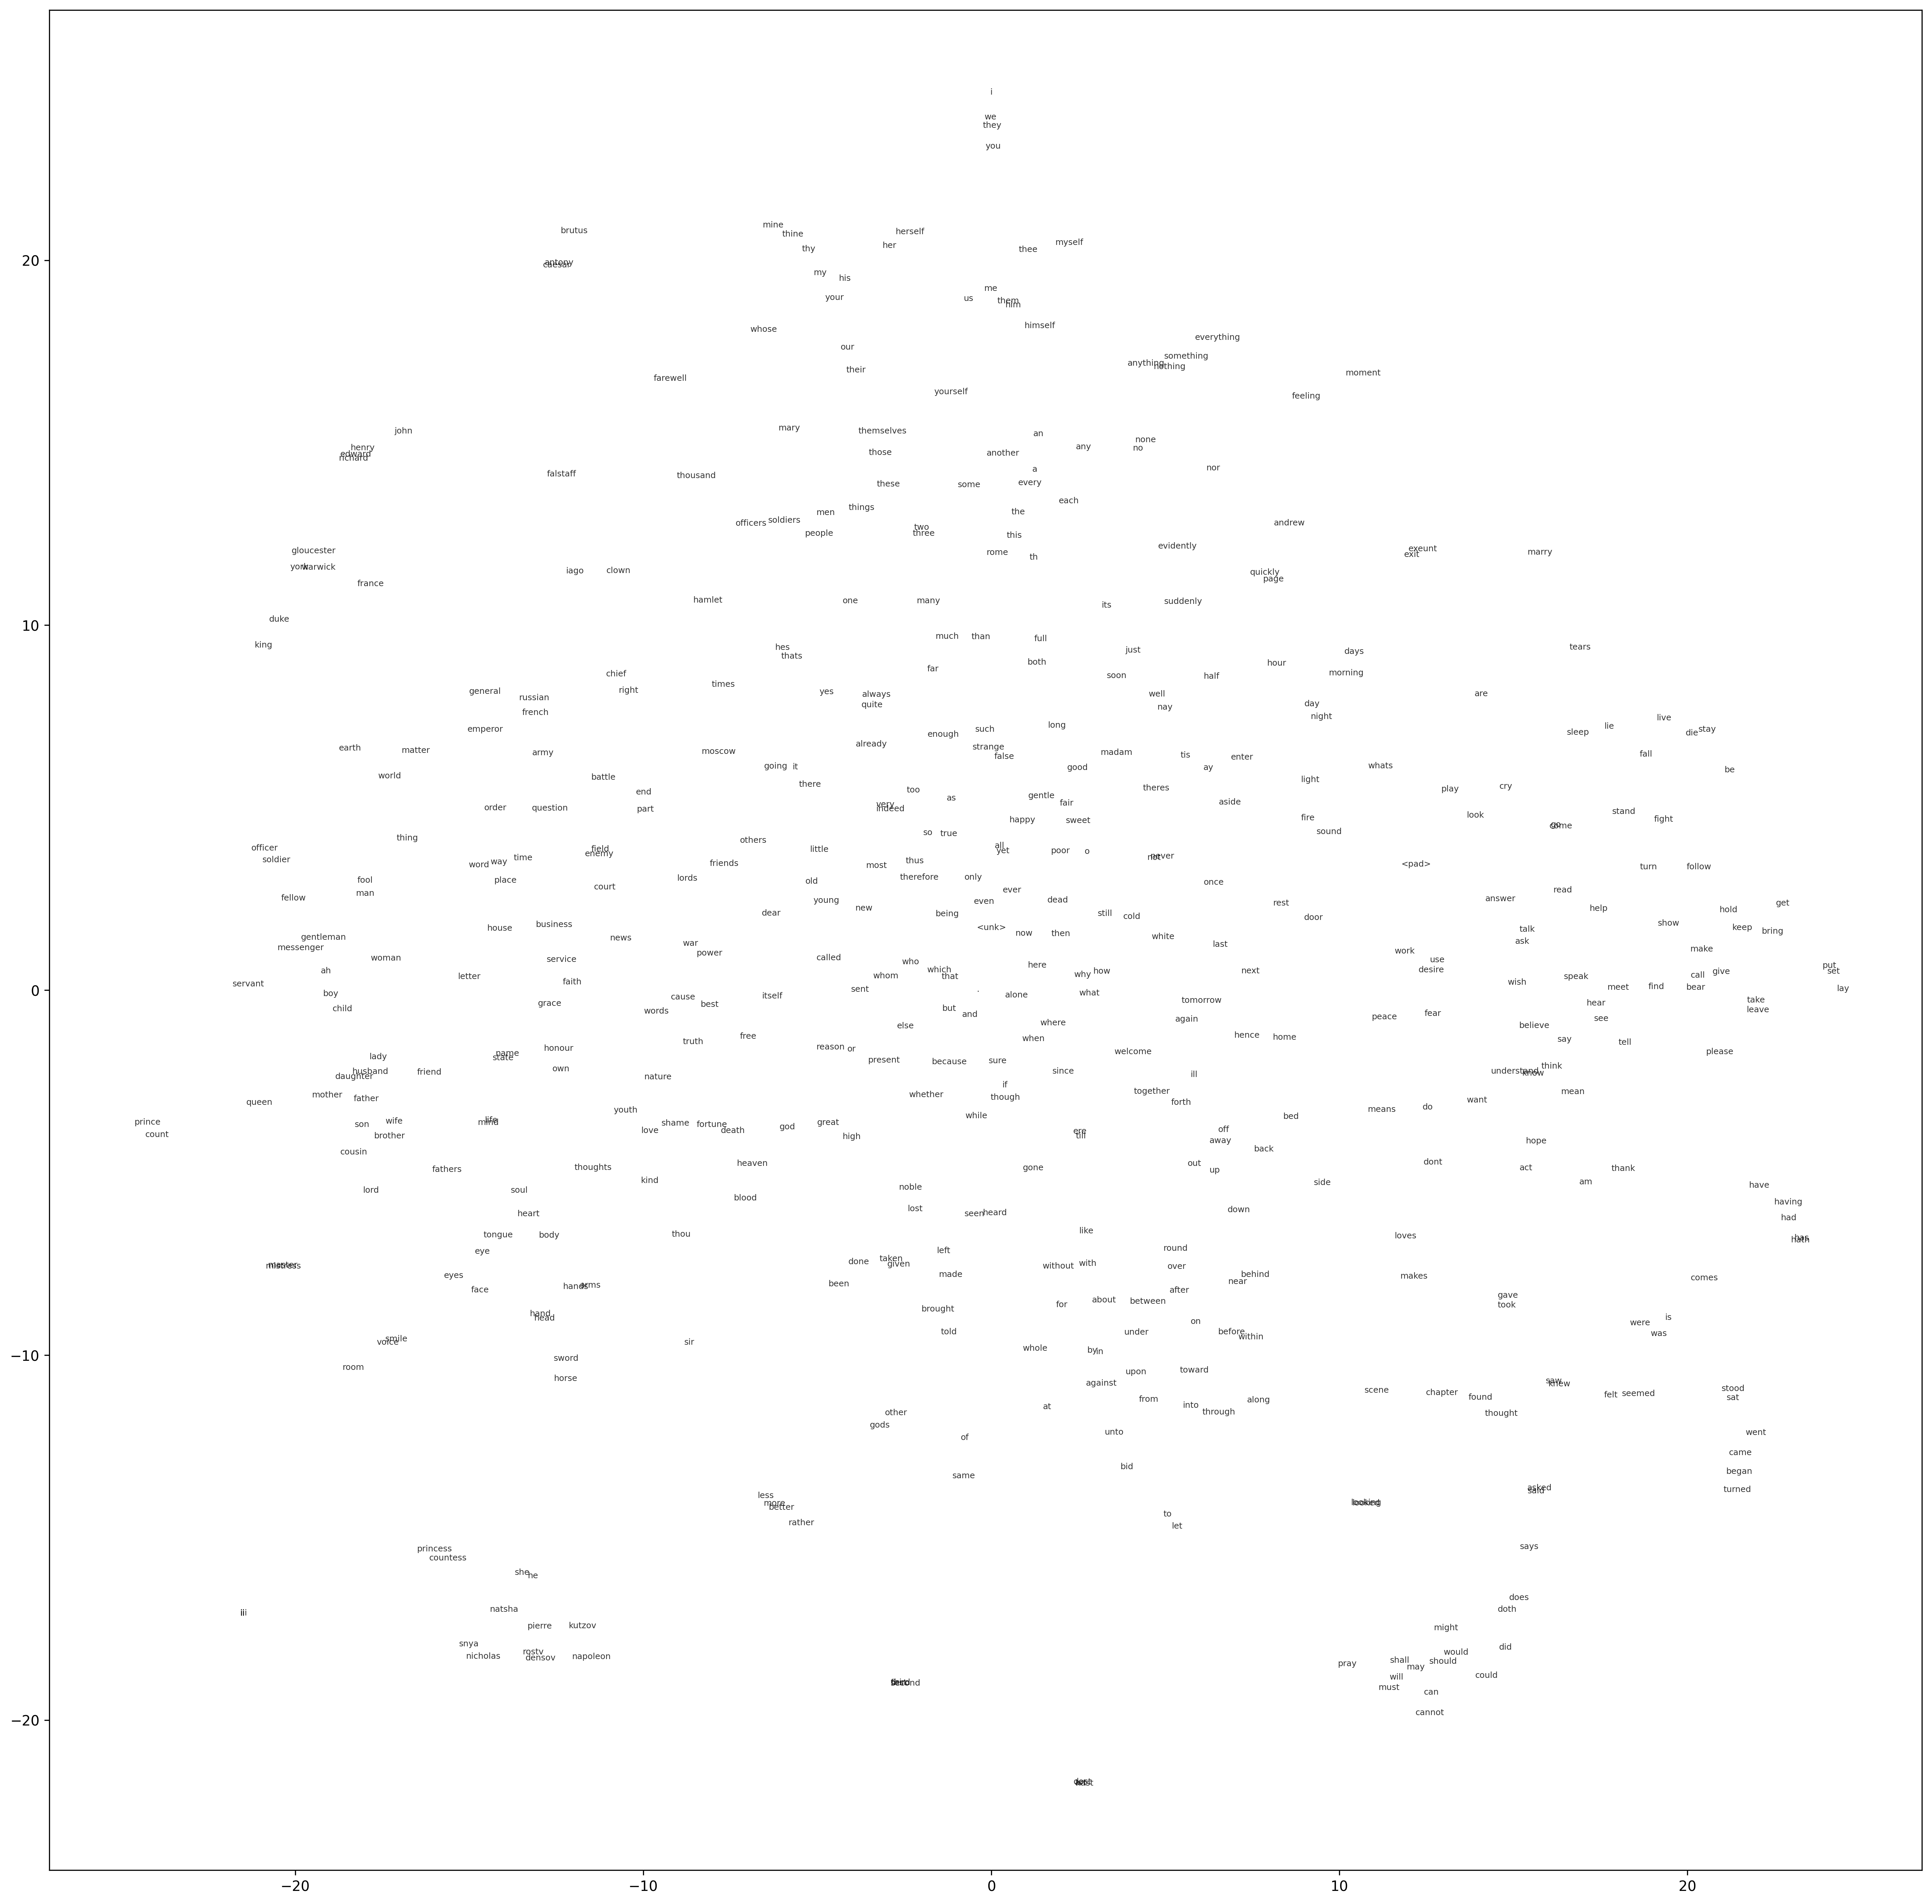

In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', perplexity=30)
low_dim_embedding = tsne.fit_transform(E[:500,:])
labels = [reverse_vocab[i] for i in range(500)]
fig, ax1 = plt.subplots(1,1, figsize=(24,24), dpi=300)

ax1.scatter(low_dim_embedding[:,0], low_dim_embedding[:,1], s=0)

for i in range(0,500,1):
    ax1.text(low_dim_embedding[i,0], low_dim_embedding[i,1], labels[i], fontsize=6, alpha=.8);

For the most part the words are very spread out. However, there are some similar groupings, such as character names, kings names, "having, had, hath, has, have", etc. There are also groupings by title, like "lord, servant, child, boy, mistress, father, mother, son, wife". These trends are pretty common throughout, where synonyms and antonyms are generally grouped relatively close. Finally, context words are generally grouped together which make sense because that is how the model is trained (Example "having, has, had, hath", etc).

# Part 2: Classify Sentences as Shakespeare or Tolstoy

## Data for classification

We will want the following:

1. A list of all sentences in the Shakespearean text
2. A list of all sentences in War and Peace

Let's just naively use periods to divide sentences, and also enfore a minimum sentence length of three tokens, and a maximum length of 128 tokens.

- Use the vocabulary developed above, and construct the indicated lists (as lists of lists of scalars).
- Print out several sentences from each to confirm your work.

In [100]:
def split_sentences_with_text(text, vocab):
    sentences = text.split('.')

    scalar_sentences = []
    original_sentences = []
    for sentence in sentences:
        words = sentence.strip().split()

        if len(words) < 3 or len(words) > 128:
            continue
        scalar_sentence = [get_vocab(word.lower(), vocab) for word in words]
  
        scalar_sentences.append(scalar_sentence)
        original_sentences.append(sentence.strip())
    
    return scalar_sentences, original_sentences

In [101]:
Shake_scalars, Shake_sentences = split_sentences_with_text(shakespeare_txt, vocab)
Tolstoy_scalars, Tolstoy_sentences = split_sentences_with_text(war_txt, vocab)
print("Shakespeare Sentences and Scalars:")
for scalar, sentence in zip(Shake_scalars[:3], Shake_sentences[:3]):
    print(f"Sentence: {sentence}")
    print(f"Scalars: {scalar}")
    print()

print("Tolstoy Sentences and Scalars:")
for scalar, sentence in zip(Tolstoy_scalars[:3], Tolstoy_sentences[:3]):
    print(f"Sentence: {sentence}")
    print(f"Scalars: {scalar}")
    print()

Shakespeare Sentences and Scalars:
Sentence: ﻿The Project Gutenberg eBook of The Complete Works of William Shakespeare
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever
Scalars: [1, 824, 858, 4425, 6, 3, 2308, 1463, 6, 1720, 1, 27, 4425, 18, 19, 3, 389, 6, 838, 3596, 9, 3, 2720, 2291, 4, 120, 141, 1066, 6, 3, 210, 32, 41, 1872, 4, 15, 508, 41, 1, 5441]

Sentence: You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www
Scalars: [11, 97, 3270, 1, 112, 17, 124, 50, 1, 17, 254, 3, 1112, 6, 3, 824, 858, 3207, 6360, 15, 27, 4425, 50, 1, 32, 5637]

Sentence: If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook
Scalars: [42, 11, 44, 16, 6361, 9, 3, 2720, 1, 11, 37, 28, 5, 3157, 3, 1041, 6, 3, 626, 105, 11, 44, 6361, 107, 3827,

## Dataset + Collate Function

- Now, construct a Dataset that consists of all sentences with a corresponding label (use $0$ for Tolstoy, $1$ for Shakespeare)
- Split this data into 80% training and 20% testing set. Further split 10% of the training set off for validation.
- Also, construct a collate function that returns a batch of padded sequences (since our sentences will all be different lengths), the associated labels, as well as the unpadded sentence lengths
- Finally, use your Datasets and collate function to create training, validation, and testing DataLoaders. For the training and validation loaders, use a batch size of 64 and `shuffle=True`


In [102]:
class TextClassificationDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.labels[idx])

In [103]:
from sklearn.model_selection import train_test_split

all_sentences = Shake_scalars + Tolstoy_scalars
all_labels = [1] * len(Shake_scalars) + [0] * len(Tolstoy_scalars)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    all_sentences, all_labels, test_size=0.2, random_state=42
)

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_sentences, train_labels, test_size=0.1, random_state=42
)

In [104]:
def collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(s) for s in sentences] 
    padded_sentences = pad_sequence(sentences, batch_first=True)
    
    labels = torch.tensor(labels)
    
    return padded_sentences, labels, torch.tensor(lengths)

In [105]:
train_dataset = TextClassificationDataset(train_sentences, train_labels)
val_dataset = TextClassificationDataset(val_sentences, val_labels)
test_dataset = TextClassificationDataset(test_sentences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate)

## Classification Model

Construct a classification model with the following characteristics:

1. Pass input through an embedding layer (with dimension 32)
2. Pass through a recurrent component consisting of **two hidden layers of LSTMs** with **64 neurons each**,
3. Pass the **final hidden state** a final fully connected component with a single output neuron
4. (Sigmoid layer; you may put the sigmoid activation function in the model or deal with it separately)

Create your model class with the format:

```
class ClassificationModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):        
        
    def forward(self, x, lengths):
        ...
```


In [106]:
class ClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32):
        super(ClassificationModel, self).__init__()
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
     
        packed_input = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
     
        _, (hidden, _) = self.lstm(packed_input)
        
        final_hidden = hidden[-1]
       
        output = self.fc(final_hidden)
      
        output = self.sigmoid(output)
        return output

In [107]:
embedding_dim = 32   
model = ClassificationModel(len(vocab), embedding_dim)

### Construct and Train

Initialize a model: **Use the trained embedding matrix from your CBOW model as the initial weights for the embedding layer**

Once you've created the model, use an appropriate loss function and an Adam optimizer with a learning rate of `.001` to train the model for a single epoch; for each training iteration, determine the model accuracy on the training batch as well as a random validation batch.

- Plot the training and validation accuracy as a function of batch number. You should see both accuracies rapidly approach and oscillate around 95% or more.
- Also determine the model accuracy on the testing dataset. It should be over 95%.

In [108]:
model.embedding.weight.data.copy_(torch.tensor(E))
model.embedding.weight.requires_grad = True 

In [109]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

In [110]:
model.train()
training_accuracy = []
validation_accuracy = []
for batch_idx, (inputs, labels, lengths) in enumerate(train_loader):
    optimizer.zero_grad() 
    outputs = model(inputs, lengths).squeeze()
    loss = criterion(outputs, labels.float())
    loss.backward()
    optimizer.step()

    predictions = (outputs > 0.5).long()
    correct_train = (predictions == labels).sum().item()
    train_acc = correct_train / len(labels) * 100
    training_accuracy.append(train_acc)

    val_inputs, val_labels, val_lengths = next(iter(val_loader))
    val_outputs = model(val_inputs, val_lengths).squeeze()
    val_predictions = (val_outputs > 0.5).long()
    correct_val = (val_predictions == val_labels).sum().item()
    val_acc = correct_val / len(val_labels) * 100
    validation_accuracy.append(val_acc)

print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, "
          f"Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

Batch 995/996, Loss: 0.1957, Training Accuracy: 92.31%, Validation Accuracy: 98.44%


In [111]:
def evaluate_model(model, loader):
    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels, lengths in loader:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            outputs = model(inputs, lengths).squeeze()
            predictions = (outputs > 0.5).long()
            correct += (predictions == labels).sum().item()
            total += len(labels)

    accuracy = correct / total * 100
    return accuracy

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 94.29%


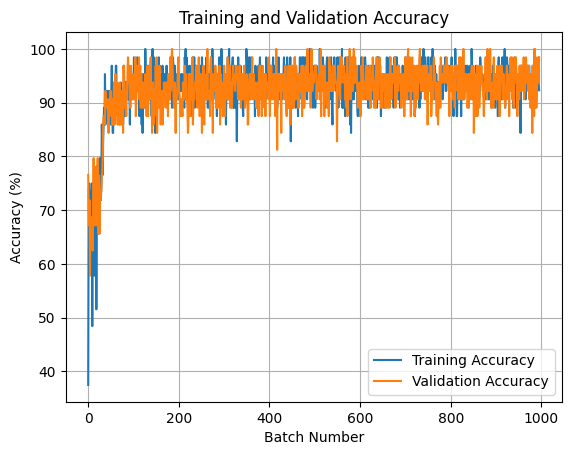

In [112]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Visualize some predictions

Take 16 random sentences from the testing dataset and print, along with the author source and the model-predicted probabilities they are Tolstoy vs. Shakespeare. The following is an example using horizontal bar plots to visualize this probability, where:
1. Blue text indicates a Tolstoy sentence; Red text indicates a Shakespeare sentence
2. The width of the blue bar is proportional to the model-predicted probability the sentence is Tolstoy, and a similar pattern holds for the red bar and Shakespeare.

In [113]:
import random
def visualize_predictions(model, loader, reverse_vocab, num_samples=16):
    model.eval()  
    predictions = []

    with torch.no_grad():
        for inputs, labels, lengths in loader:
            outputs = model(inputs, lengths).squeeze()
            probs = outputs.cpu().numpy() 
            labels = labels.cpu().numpy()  
            inputs = inputs.cpu().numpy()  

            for i in range(len(probs)):
                sentence = " ".join([reverse_vocab.get(idx, '<UNK>') for idx in inputs[i] if idx != vocab['<pad>']])
                predictions.append((sentence, labels[i], probs[i]))

    random_samples = random.sample(predictions, min(num_samples, len(predictions)))

    plt.figure(figsize=(14, 10))
    for i, (sentence, true_label, pred_prob) in enumerate(random_samples):
        blue_width = 1-pred_prob
        red_width = pred_prob
        ###print(true_label, pred_prob)

        plt.barh(i, blue_width, color='blue', alpha=0.7, label="Tolstoy" if i == 0 else "")  
        plt.barh(i, red_width, left=blue_width, color='red', alpha=0.7, label="Shakespeare" if i == 0 else "")  
        true_label_text = "Tolstoy" if true_label == 0 else "Shakespeare"
        plt.text(0.01, i, f"[{true_label_text}] {sentence[:100]}...", va='center', ha='left', fontsize=9)

    plt.yticks(range(len(random_samples)), []) 
    plt.xlabel("Predicted Probability")
    plt.title("Correct Predictions Visualization: Tolstoy (Blue) vs Shakespeare (Red)")
    plt.legend(loc="lower right")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

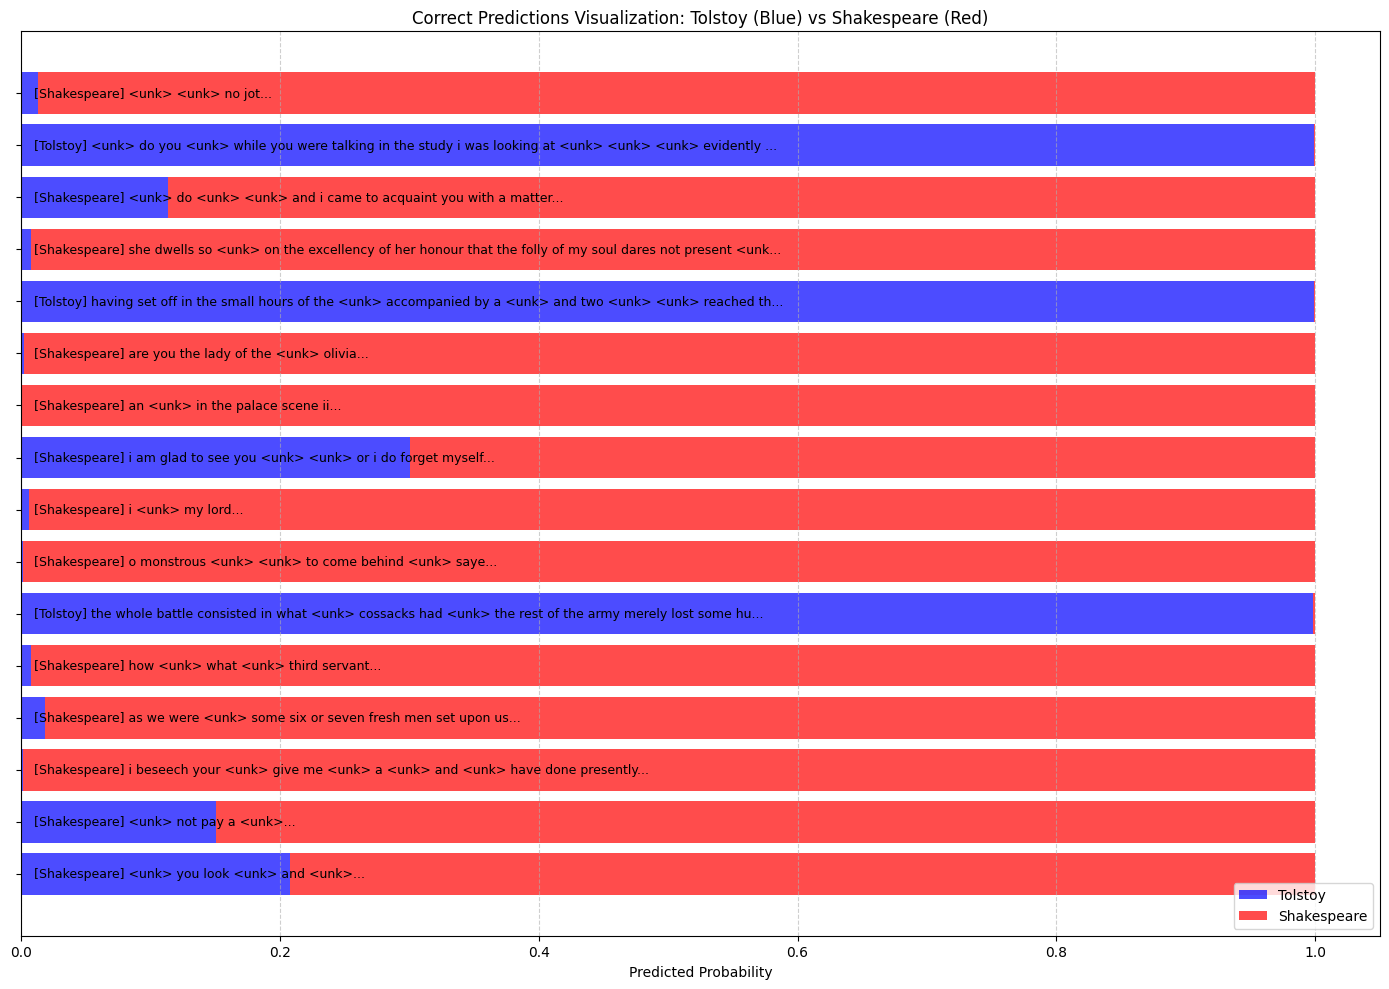

In [114]:
visualize_predictions(model, test_loader, reverse_vocab)

### Visualize some incorrect predictions

Do the same thing as above, but now give 16 examples where the model gave the incorrect (binary) prediction. An example follows.

In [115]:
def visualize_only_incorrect_predictions(model, loader, reverse_vocab, num_samples=16):
    model.eval() 
    incorrect_predictions = []

    with torch.no_grad():
        for inputs, labels, lengths in loader:
            outputs = model(inputs, lengths).squeeze()
            probs = outputs.cpu().numpy()  
            labels = labels.cpu().numpy()  
            inputs = inputs.cpu().numpy()  

            for i in range(len(probs)):
                predicted_label = 0 if probs[i] < 0.5 else 1 
                true_label = labels[i]
                if predicted_label != true_label:
                    sentence = " ".join([reverse_vocab.get(idx, '<UNK>') for idx in inputs[i] if idx != vocab['<pad>']])
                    incorrect_predictions.append((sentence, true_label, probs[i]))

    random_samples = random.sample(incorrect_predictions, min(num_samples, len(incorrect_predictions)))

    plt.figure(figsize=(14, 10))
    for i, (sentence, true_label, pred_prob) in enumerate(random_samples):
        blue_width = pred_prob
        red_width = 1-pred_prob
       
        plt.barh(i, blue_width, color='blue', alpha=0.7, label="Tolstoy" if i == 0 else "")
        plt.barh(i, red_width, left=blue_width, color='red', alpha=0.7, label="Shakespeare" if i == 0 else "")
        true_label_text = "Tolstoy" if true_label == 1 else "Shakespeare"
        plt.text(0.01, i, f"[{true_label_text}] {sentence[:80]}...", va="center", ha="left", fontsize=9, color="black")

    plt.yticks(range(len(random_samples)), []) 
    plt.xlabel("Predicted Probability")
    plt.title("Incorrect Predictions: Tolstoy (Blue) vs Shakespeare (Red)")
    plt.legend(loc="lower right")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

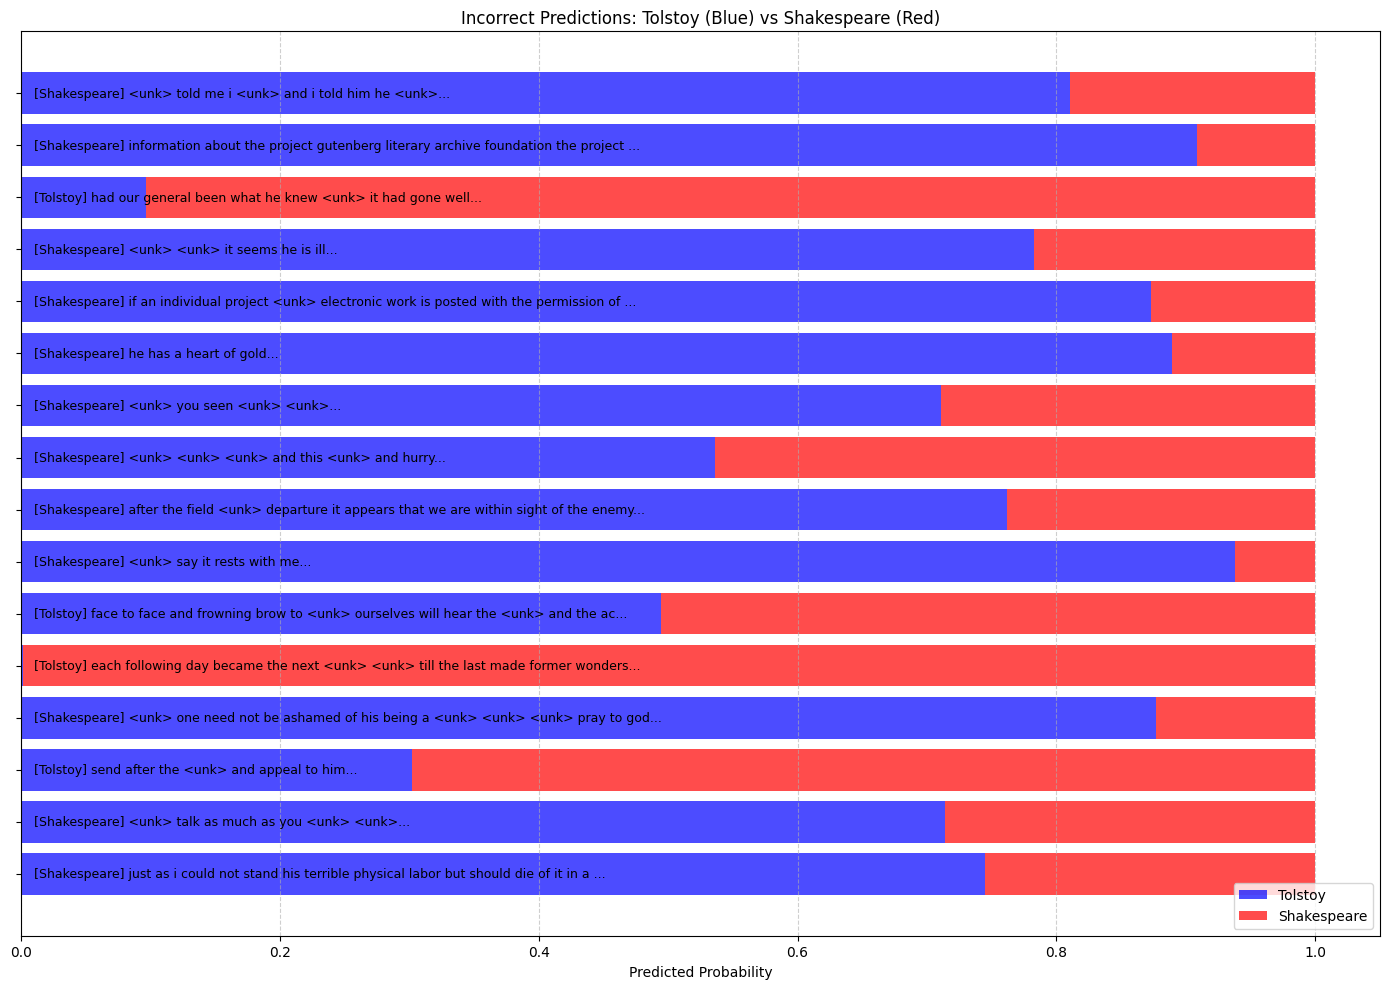

In [116]:
visualize_only_incorrect_predictions(model, test_loader, reverse_vocab)

# Part 3: Shakespearean Text Generator

### 1. Create a new vocabulary consisting of the unique **characters** in our Shakespearean text
- Tokenize texts to individual characters
- Determine all unique characters
- Create a vocabulary dictionary that maps individual characters to an arbitrary scalar
- Also create a reverse vocabulary dictionary that maps from the scalar to the character
- Save the vocabulary size

In [ ]:
def create_char_vocab(text):
    unique_chars = sorted(set(text))  
    unique_chars.append('<UNK>')
    vocab = {char: idx for idx, char in enumerate(unique_chars)}
    reverse_vocab = {idx: char for char, idx in vocab.items()}
    vocab_size = len(vocab)

    return vocab, reverse_vocab, vocab_size

In [43]:
vocab_gen, reverse_vocab_gen, vocab_size_gen = create_char_vocab(shakespeare_txt)

In [77]:
list(vocab_gen.items())[:20]

[('\t', 0),
 ('\n', 1),
 (' ', 2),
 ('!', 3),
 ('#', 4),
 ('$', 5),
 ('%', 6),
 ('&', 7),
 ("'", 8),
 ('(', 9),
 (')', 10),
 ('*', 11),
 (',', 12),
 ('-', 13),
 ('.', 14),
 ('/', 15),
 ('0', 16),
 ('1', 17),
 ('2', 18),
 ('3', 19)]

In [78]:
list(reverse_vocab_gen.items())[:20]

[(0, '\t'),
 (1, '\n'),
 (2, ' '),
 (3, '!'),
 (4, '#'),
 (5, '$'),
 (6, '%'),
 (7, '&'),
 (8, "'"),
 (9, '('),
 (10, ')'),
 (11, '*'),
 (12, ','),
 (13, '-'),
 (14, '.'),
 (15, '/'),
 (16, '0'),
 (17, '1'),
 (18, '2'),
 (19, '3')]

### 2. Prepare data for character prediction

- For our model, we want sequences of length 128 as input, and length 128 as output
- That is, we will make a sequence-to-sequence model, with the ouput the input shifted by 1 word (plus the next word)
- To prep our data, construct all possible sub-sequences of length 129 (the first 128 characters will be the input, the last 128 the output)
- Wrap these sequences in a PyTorch `DataSet` that returns an input and output sequence as torch tensors
- Also create a DataLoader with batch size 64

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, text, vocab, seq_length=128):
        self.text = text
        self.vocab = vocab
        self.seq_length = seq_length

        self.encoded_text = [vocab[char] for char in text]

        self.data = [
            (
                self.encoded_text[i:i + seq_length],
                self.encoded_text[i + 1:i + seq_length + 1]  
            )
            for i in range(len(self.encoded_text) - seq_length)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, output_seq = self.data[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(output_seq, dtype=torch.long)

In [ ]:
def create_dataloader(text, vocab, batch_size=64, seq_length=128):
    dataset = ShakespeareDataset(text, vocab, seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
dataloader = create_dataloader(shakespeare_txt, vocab_gen, batch_size=64, seq_length=128)

## Character Prediction Model

Now, create a sequence-to-sequence model that predicts an output sequence from an input sequence (again, the output is the input shifted by one to the right).

The model should have the following structure:

1. Embedding layer
2. Recurrent component consisting of two **LSTM** layers with 64 neurons each, **as well as 20% dropout**
3. An output layer with `vocab_size` neurons, where this is the size of your vocabulary

Call this model `ShakespeareModel()`, and define using the format:

```
class ShakespeareModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, rnn_size=64):
        ...
        
    def forward(self, x, hidden, cell):
        ...
        
    #OPTIONALLY:
    def init_hidden(self, batch_size):
        ...
```

Use an embedding matrix dimension of 32.

In [ ]:
class ShakespeareModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32, rnn_size=64):
        super(ShakespeareModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.rnn_size = rnn_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, rnn_size, num_layers=2, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(rnn_size, vocab_size)

    def forward(self, x, hidden, cell):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        logits = self.fc(lstm_out)
        return logits, hidden, cell

### Train the model

Now, using an appropriate loss function and optimizer, train the model until, in your judgement, you get reasonable results when creating Shakespearean text autoregressively.

In [ ]:
embedding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gen = ShakespeareModel(vocab_size_gen, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gen.parameters(), lr=0.001)
num_epochs = 1

best_loss = float('inf')
stagnation_count = 0
early_stop_threshold = 5000 

for epoch in range(num_epochs):
    model_gen.train()  
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        batch_size = inputs.size(0)
        hidden = torch.zeros(2, batch_size, model_gen.rnn_size, device=device)  
        cell = torch.zeros(2, batch_size, model_gen.rnn_size, device=device)

        logits, hidden, cell = model_gen(inputs, hidden, cell)
        logits = logits.view(-1, vocab_size_gen) 
        targets = targets.view(-1) 
        
        loss = criterion(logits, targets)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item() 
            stagnation_count = 0 
        else:
            stagnation_count += 1 

        if stagnation_count >= early_stop_threshold:
            print(f"Early stopping triggered at Epoch {epoch + 1}, Batch {batch_idx + 1}. Loss did not improve for {early_stop_threshold} batches.")
            break

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(dataloader):.4f}")

    if stagnation_count >= early_stop_threshold:
        break

Epoch [1/1], Batch [100], Loss: 3.2532
Epoch [1/1], Batch [200], Loss: 2.9702
Epoch [1/1], Batch [300], Loss: 2.6348
Epoch [1/1], Batch [400], Loss: 2.4943
Epoch [1/1], Batch [500], Loss: 2.3977
Epoch [1/1], Batch [600], Loss: 2.3504
Epoch [1/1], Batch [700], Loss: 2.2810
Epoch [1/1], Batch [800], Loss: 2.2115
Epoch [1/1], Batch [900], Loss: 2.1623
Epoch [1/1], Batch [1000], Loss: 2.1565
Epoch [1/1], Batch [1100], Loss: 2.1363
Epoch [1/1], Batch [1200], Loss: 2.1192
Epoch [1/1], Batch [1300], Loss: 2.0639
Epoch [1/1], Batch [1400], Loss: 2.0627
Epoch [1/1], Batch [1500], Loss: 2.0619
Epoch [1/1], Batch [1600], Loss: 2.0717
Epoch [1/1], Batch [1700], Loss: 1.9754
Epoch [1/1], Batch [1800], Loss: 2.0097
Epoch [1/1], Batch [1900], Loss: 1.9807
Epoch [1/1], Batch [2000], Loss: 1.9934
Epoch [1/1], Batch [2100], Loss: 1.9043
Epoch [1/1], Batch [2200], Loss: 1.9459
Epoch [1/1], Batch [2300], Loss: 1.9516
Epoch [1/1], Batch [2400], Loss: 1.9090
Epoch [1/1], Batch [2500], Loss: 1.8988
Epoch [1/

## Autoregressively Generate Text

Using a starting sentence seed, generate 1,000 characters autoregressively:

1. Given the logits for the next character, use a `Categorical` object to draw the next letter from a categoral distribution. Additionally, you can multiply the logits by a scaling factor to make the text more or less random.

2. Give three example results from using the seed sentence "Cowards die many times before their deaths; the valiant never taste of death but once"

One example follows.

In [ ]:
from torch.distributions.categorical import Categorical
def generate_text_autoregressively(model, start_seq, vocab, reverse_vocab, length=1000, temperature=1.0):
    model.eval() 

    input_seq = torch.tensor(
        [vocab[char] if char in vocab else vocab['<UNK>'] for char in start_seq], 
        dtype=torch.long
    ).unsqueeze(0)  
    hidden = torch.zeros(2, 1, model.rnn_size) 
    cell = torch.zeros(2, 1, model.rnn_size)

    generated_text = start_seq
    for _ in range(length):
        logits, hidden, cell = model(input_seq, hidden, cell)
        logits = logits[:, -1, :]  
        scaled_logits = logits / temperature
        probs = nn.functional.softmax(scaled_logits, dim=-1)
        next_char_idx = Categorical(probs).sample().item()
        next_char = reverse_vocab[next_char_idx]
        generated_text += next_char

        input_seq = torch.tensor([[next_char_idx]], dtype=torch.long)

    return generated_text

In [66]:
seed_sentence = "Cowards die many times before their deaths; the valiant never taste of death but once"
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=.01)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but once
The stand the stand the stand the stand the stand the stand the strange
The stand the stand the stand the stand the stand the stand of the strange
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the strange the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand the stand the stand
The stand the stand the stand the stand the stand

In [69]:
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=.25)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but once
The wind the speak the seased the strange of the more the love me the like the honour
That the world in the shall be heart of my man to be the struke the strange
The fair to me the wanting in the earth the than the bear her content
The fair and her shall to the father and bear the love the say
That the strange the love the fair and the strange the soul,
And I am the world that the world to the proceed and be the way,
And for the honour and the love him and do so heart of the fair and the company
The hand of the warrant to me the bear the company,
And my lord, the fair and the company to the company,
And what then with my part and the death of the heart
That the common of the man with the sent the seam of the beard
That the man in the life of the books of the sent the streat
The sent and the great the same of the grace and shall not with the prove and done
To the love the man and do sho

In [67]:
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=.5)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but once of the fair well the
propering pray your flower to be a compose,
And then the heart to his bid the princess as the father
The stand of the fortunes and a seen your own will perceive,
And a that is stand the will come to before it thee good
have that a common and she would be with the body
To call me to have to the place of the instrument.

SECOND LORD.
Good to the new she as the rest of her the promise of the strange,
And well him the mind toreter prove the honour and would be this come,
That that an excellent of his part but the date of the shall any doth
of fire of it with the saw and the land the earth.

DUKE.
I am the better, the hand, and if uncould for this assident and the prove
For a great a call and thee to the propents,
And by the heart the water and strange
The good to the mother and the wit the world for the lady.

FALSTAFF.
Is then had good the courtesy hear and their grac

In [71]:
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=.75)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but once the Lady
To her sights and guness in two be shall such is so the ground to me.

GROGULY.
My counterady! Sir and store princess.

CADE.
France to this deed,
But you to her sender the lists of Thind part so command;
The sheeling him and France and bring as heart with thine the god his
maiderion. When a found such of the pleasure thy dathing or
fires, and all times in the ever is him him of a least,
The cremple and the time thee, but thou in excurnent, Candan, and night.

PRINCE.
Good man we enter for their lord, but earth.

ALLICELLE.
I’ll with companio.

HAMLET.
First good therefore many thee treasom; and sound,
And this she with stable by the courn,
And he will be worst there hath defenced of you,
To see her company is to my prayer with forces,
We endonone did do shall be drum, for before, I were not desance in the master
To any name you such the duty things the King
To promise of the 

In [68]:
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=1)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but once,
Would they is speaktansed delicelting long but which ange affer
And you wilt by the caber all for Annsward,
She out, and few by morty. Florgy heath.

PROAPS ANWICHLES.
Gomed, turn for his pialthasing bear
the roneed sir by it, and then fiers. But think the very such
shall report, and rise herly but him all the scores in ’’iby possiger?
I will we propers. [_holy to speak daughtone by thy is the breed find a compy mothing lost,
The certer, go with may hold-sobal.

MISTRESS QUINDULIUS, said whom swear!
And go obsert and I can tends so death.

SECOND LORY.
Lownen!_]

CELIA.
Why look a too.

KING.
Ye!

EDGAR.
Backan thee. As father for you; what there’s no. What will.

BAMDULATACESS.
No, lady the secorses comes.
The most, good grown a jest and to him.

CLEOPATRA.
Qee, and more some youth’s tongued
What finds upon a world, and play.
[_Tilsed, that my lady Fool._]

CONSTAWLEN.
Within Youn an

In [70]:
generated_text = generate_text_autoregressively(model_gen, seed_sentence, vocab_gen, reverse_vocab_gen, length=1000, temperature=1.25)
print(f"Generated Text:\n{generated_text[:1000]}\n")

Generated Text:
Cowards die many times before their deaths; the valiant never taste of death but oncely in Pet
we on, away, resee—enorly. If he lits, along art Deen the beard’s charded
But all-dear apompanity brageraulind whosely,
Where tell shall not, it, Penerceless;
Nay hauls, this these?
Pakfost to old for breaks; and on not, Depark’d.
I’ll we near Hever thyself?

SIR HOBR,” Hold, Syel you oursily aadia”ing iago, imas the plamal, Captam,
Tinms but I 1

ARI LADO! Sail disbair?

SIXCANUS.
What is your net for the service
mears, or Brid’st Seeving on’t be you.

WITHANA.
Ad’ar ’tis Allight wrong
My horse and yours.
Arew wis out my Secr, mive is cordleth.
Of Sulipi: that need swear of birthole
Againte Tean quiscans Officend o’ th’ waning?

TIMON.
No, may in Cisite needs?
Than it ha,
Whice ofter a this kings—or a a tark.

MENENIUS.
Marce-dishands.
Arm sty, and amonkicious.—
VIRINA.
What stair, adneuty drew, as any.

CASSIO.
That,
They lend I can wherewer he uslill;
Fhar ho. Exeman is new

Lower temp makes the generation only predict/generate the same few words while higher temp makes the generation more random and nonsensical.